# ⚛️ Orquestra QRE - Interactive Quantum Resource Estimation

This notebook provides an interactive way to explore quantum resource estimation without complex setup.

In [1]:
# Import necessary libraries
import sys
import os
sys.path.append(os.path.abspath('.'))

from orquestra_qre.quantum import CircuitGenerator, QuantumResourceEstimator
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass
import numpy as np

# Define hardware provider model
@dataclass
class HardwareProvider:
    name: str
    max_qubits: int
    coherence_time_us: float
    single_qubit_error: float
    two_qubit_error: float
    connectivity: str

# Initialize hardware providers
HARDWARE_PROVIDERS = [
    HardwareProvider("IBM", 127, 100, 1e-3, 1e-2, "Heavy Hex"),
    HardwareProvider("Google", 72, 150, 5e-4, 1e-2, "Sycamore"),
    HardwareProvider("IonQ", 32, 1000, 1e-4, 2e-3, "All-to-All"),
    HardwareProvider("Rigetti", 80, 80, 2e-3, 1.5e-2, "Lattice"),
    HardwareProvider("Custom", 1000, 10000, 1e-5, 1e-4, "Custom")
]

# Initialize error correction codes
ERROR_CORRECTION_CODES = {
    "None": {"overhead": 1, "logical_to_physical": lambda n: n},
    "Surface Code": {"overhead": 20, "logical_to_physical": lambda n: n * 20},
    "Repetition Code": {"overhead": 5, "logical_to_physical": lambda n: n * 5}
}

# Initialize components
circuit_gen = CircuitGenerator()
estimator = QuantumResourceEstimator()

print("🚀 Orquestra QRE initialized successfully!")

# Define hardware-aware estimation function
def hardware_aware_estimate(circuit, estimator, provider, ec_code):
    """Perform hardware-aware resource estimation."""
    logical_qubits = circuit.num_qubits
    physical_qubits = ec_code["logical_to_physical"](logical_qubits)
    estimate = estimator.estimate_resources(circuit)
    
    # Adjust runtime and fidelity for error correction (simple model)
    overhead = ec_code["overhead"]
    estimate.estimated_runtime_ms *= overhead
    estimate.estimated_fidelity **= overhead
    
    # Hardware feasibility checks
    warnings = []
    if physical_qubits > provider.max_qubits:
        warnings.append(f"⚠️ Circuit requires {physical_qubits} physical qubits, but {provider.name} supports only {provider.max_qubits}.")
    if estimate.estimated_runtime_ms > provider.coherence_time_us / 1000:
        warnings.append(f"⚠️ Estimated runtime {estimate.estimated_runtime_ms:.1f} ms exceeds {provider.name} coherence time ({provider.coherence_time_us} μs).")
    
    # Add custom attributes
    estimate.hardware_warnings = warnings
    estimate.physical_qubits = physical_qubits
    estimate.selected_provider = provider.name
    estimate.selected_ec_code = ec_code
    
    return estimate

🚀 Orquestra QRE initialized successfully!


## 🔬 Generate Quantum Circuits

## 🖥️ Hardware Providers and Error Correction

Orquestra QRE supports multiple hardware providers and error correction codes.

### Hardware Providers:
- IBM: 127 qubits, Heavy Hex connectivity
- Google: 72 qubits, Sycamore connectivity
- IonQ: 32 qubits, All-to-All connectivity
- Rigetti: 80 qubits, Lattice connectivity
- Custom: User-defined parameters

### Error Correction Codes:
- Surface Code: ~20x physical qubit overhead
- Repetition Code: ~5x physical qubit overhead

Let's explore how different hardware and error correction choices impact resource estimates.

In [5]:
# Explore hardware provider impact
def compare_hardware_providers(circuit):
    """Compare resource estimates across hardware providers."""
    results = []
    
    # No error correction
    ec_code = ERROR_CORRECTION_CODES["None"]
    
    for provider in HARDWARE_PROVIDERS:
        hw_estimate = hardware_aware_estimate(circuit, estimator, provider, ec_code)
        
        # Store results
        results.append({
            "Provider": provider.name,
            "Logical Qubits": hw_estimate.num_qubits,
            "Physical Qubits": hw_estimate.physical_qubits,
            "Runtime (ms)": hw_estimate.estimated_runtime_ms,
            "Fidelity (%)": hw_estimate.estimated_fidelity * 100,
            "Warnings": len(hw_estimate.hardware_warnings) > 0
        })
    
    # Convert to DataFrame for analysis
    df = pd.DataFrame(results)
    return df

# Generate different types of circuits for analysis
circuits = {
    "Bell State": circuit_gen.generate_bell_state(),
    "Grover (3q)": circuit_gen.generate_grover_search(3),
    "QFT (3q)": circuit_gen.generate_qft(3),
    "Random (4q)": circuit_gen.generate_random_circuit(4, 8)
}

# Select a demo circuit
demo_circuit = circuits["QFT (3q)"]  # Let's use QFT for demo
print(f"Analyzing QFT circuit with {demo_circuit.num_qubits} qubits")

# Compare providers
provider_comparison = compare_hardware_providers(demo_circuit)
provider_comparison

# Select a demo circuit
demo_circuit = circuits["QFT (3q)"]  # Let's use QFT for demo
print(f"Analyzing QFT circuit with {demo_circuit.num_qubits} qubits")

# Compare providers
provider_comparison = compare_hardware_providers(demo_circuit)
provider_comparison

Analyzing QFT circuit with 3 qubits
Analyzing QFT circuit with 3 qubits


,Provider,Logical Qubits,Physical Qubits,Runtime (ms),Fidelity (%),Warnings
0,IBM,3,3,141.0,98.59,True
1,Google,3,3,141.0,98.59,True
2,IonQ,3,3,141.0,98.59,True
3,Rigetti,3,3,141.0,98.59,True
4,Custom,3,3,141.0,98.59,True


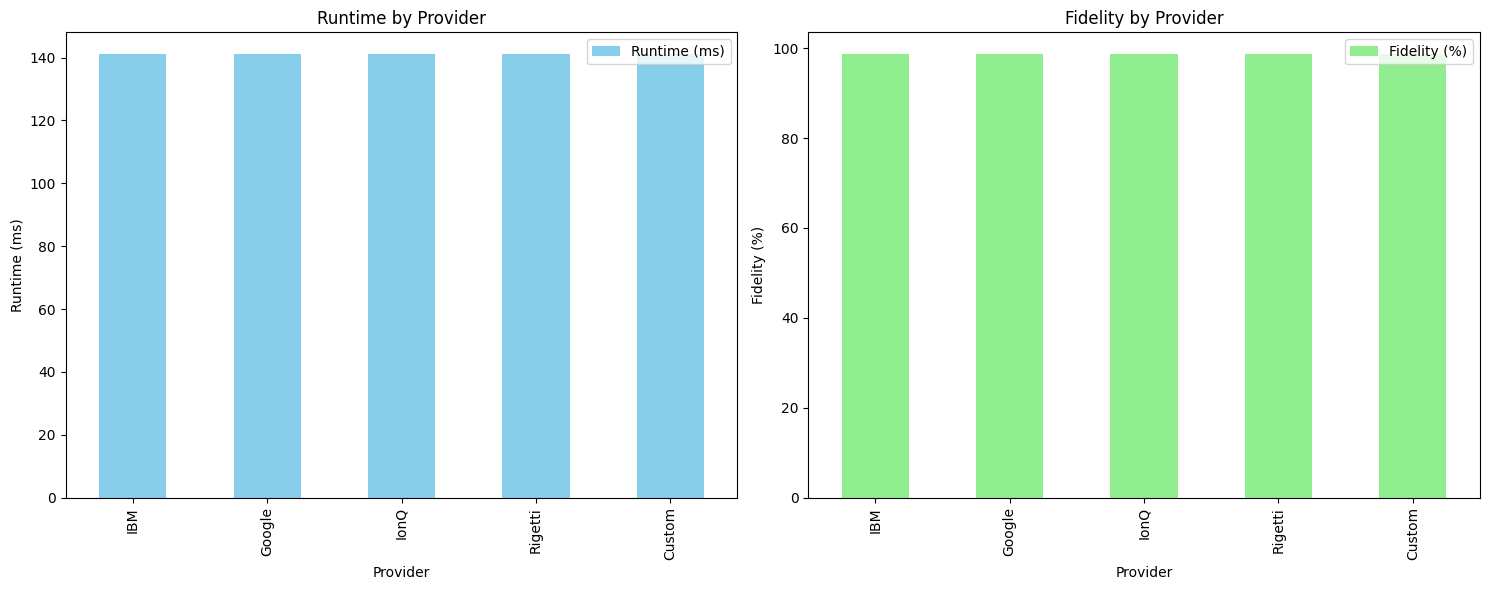

⚠️ Warning for IBM: Circuit may exceed hardware limits
⚠️ Warning for Google: Circuit may exceed hardware limits
⚠️ Warning for IonQ: Circuit may exceed hardware limits
⚠️ Warning for Rigetti: Circuit may exceed hardware limits
⚠️ Warning for Custom: Circuit may exceed hardware limits


In [6]:
# Visualize provider comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Runtime comparison
provider_comparison.plot(
    x='Provider', 
    y='Runtime (ms)', 
    kind='bar', 
    color='skyblue',
    title='Runtime by Provider',
    ax=ax1
)
ax1.set_ylabel('Runtime (ms)')

# Fidelity comparison
provider_comparison.plot(
    x='Provider', 
    y='Fidelity (%)', 
    kind='bar',
    color='lightgreen',
    title='Fidelity by Provider',
    ax=ax2
)
ax2.set_ylabel('Fidelity (%)')

plt.tight_layout()
plt.show()

# Show warnings if any
for idx, row in provider_comparison.iterrows():
    if row['Warnings']:
        print(f"⚠️ Warning for {row['Provider']}: Circuit may exceed hardware limits")

In [8]:
# Explore error correction impact
def compare_error_correction(circuit, provider_name="IBM"):
    """Compare resource estimates with different error correction codes."""
    results = []
    
    # Get selected provider
    provider = next(p for p in HARDWARE_PROVIDERS if p.name == provider_name)
    
    for ec_name, ec_code in ERROR_CORRECTION_CODES.items():
        hw_estimate = hardware_aware_estimate(circuit, estimator, provider, ec_code)
        
        # Store results
        results.append({
            "Error Correction": ec_name,
            "Logical Qubits": hw_estimate.num_qubits,
            "Physical Qubits": hw_estimate.physical_qubits,
            "Runtime (ms)": hw_estimate.estimated_runtime_ms,
            "Fidelity (%)": hw_estimate.estimated_fidelity * 100,
            "Warnings": len(hw_estimate.hardware_warnings) > 0
        })
    
    # Convert to DataFrame for analysis
    df = pd.DataFrame(results)
    return df

# Compare error correction codes using IBM hardware
selected_provider = "IBM"
print(f"Analyzing error correction impact on {selected_provider} hardware")
ec_comparison = compare_error_correction(demo_circuit, selected_provider)
ec_comparison

Analyzing error correction impact on IBM hardware


,Error Correction,Logical Qubits,Physical Qubits,Runtime (ms),Fidelity (%),Warnings
0,None,3,3,141.0,98.590000,True
1,Surface Code,3,60,2820.0,75.276138,True
2,Repetition Code,3,15,705.0,93.146026,True


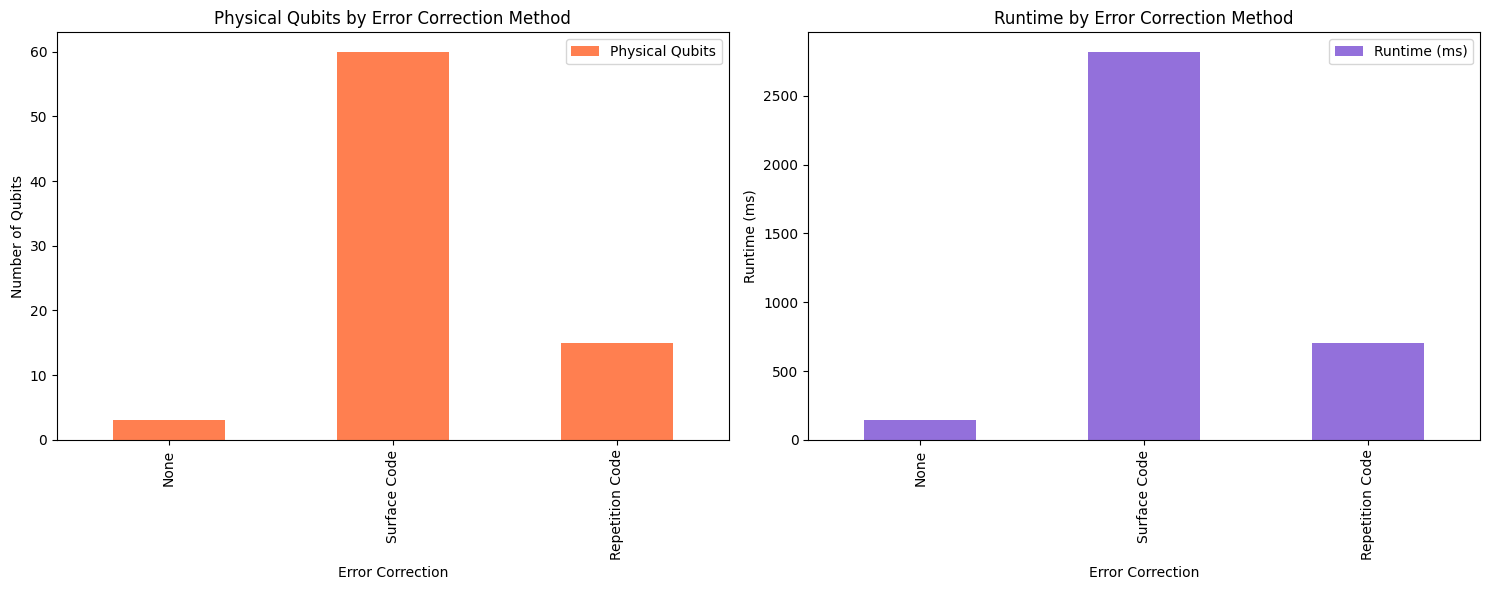

⚠️ Warning for None: Circuit may exceed hardware limits
⚠️ Warning for Surface Code: Circuit may exceed hardware limits
⚠️ Warning for Repetition Code: Circuit may exceed hardware limits


In [9]:
# Visualize error correction impact
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Physical qubits comparison
ec_comparison.plot(
    x='Error Correction', 
    y='Physical Qubits', 
    kind='bar', 
    color='coral',
    title='Physical Qubits by Error Correction Method',
    ax=ax1
)
ax1.set_ylabel('Number of Qubits')

# Runtime comparison
ec_comparison.plot(
    x='Error Correction', 
    y='Runtime (ms)', 
    kind='bar',
    color='mediumpurple',
    title='Runtime by Error Correction Method',
    ax=ax2
)
ax2.set_ylabel('Runtime (ms)')

plt.tight_layout()
plt.show()

# Show warnings if any
for idx, row in ec_comparison.iterrows():
    if row['Warnings']:
        print(f"⚠️ Warning for {row['Error Correction']}: Circuit may exceed hardware limits")

## 📈 Scaling Analysis with Error Correction

Let's examine how circuit size scales with error correction and how this impacts quantum resource requirements. This analysis helps understand the practical limitations of current hardware.

In [12]:
# Analyze scaling of QFT circuits with increasing qubit counts
def scaling_analysis():
    """Analyze how resource requirements scale with circuit size."""
    results = []
    
    # Range of qubit counts to analyze
    qubit_counts = [3, 5, 10, 20, 30, 50]
    
    # Set up hardware provider (IBM) and error correction codes
    provider = next(p for p in HARDWARE_PROVIDERS if p.name == "IBM")
    
    for num_qubits in qubit_counts:
        # Generate QFT circuit
        qft_circuit = circuit_gen.generate_qft(num_qubits)
        
        # Analyze with different error correction approaches
        for ec_name, ec_code in ERROR_CORRECTION_CODES.items():
            # Estimate resources
            hw_estimate = hardware_aware_estimate(qft_circuit, estimator, provider, ec_code)
            
            # Store results
            results.append({
                "Qubits": num_qubits,
                "Error Correction": ec_name,
                "Physical Qubits": hw_estimate.physical_qubits,
                "Runtime (ms)": hw_estimate.estimated_runtime_ms,
                "Fidelity (%)": hw_estimate.estimated_fidelity * 100,
                "Gates": hw_estimate.gate_count,
                "Exceeds Hardware": hw_estimate.physical_qubits > provider.max_qubits
            })
    
    # Convert to DataFrame
    scaling_df = pd.DataFrame(results)
    return scaling_df

# Run scaling analysis
scaling_results = scaling_analysis()
scaling_results

,Qubits,Error Correction,Physical Qubits,Runtime (ms),Fidelity (%),Gates,Exceeds Hardware
0,3,None,3,141.0,98.590000,9,False
1,3,Surface Code,60,2820.0,75.276138,9,False
2,3,Repetition Code,15,705.0,93.146026,9,False
3,5,None,5,420.0,95.800000,25,False
4,5,Surface Code,100,8400.0,42.394565,25,False
5,5,Repetition Code,25,2100.0,80.691455,25,False
6,10,None,10,1765.0,90.000000,100,False
7,10,Surface Code,200,35300.0,12.157665,100,True
8,10,Repetition Code,50,8825.0,59.049000,100,False
9,20,None,20,7230.0,90.000000,400,False


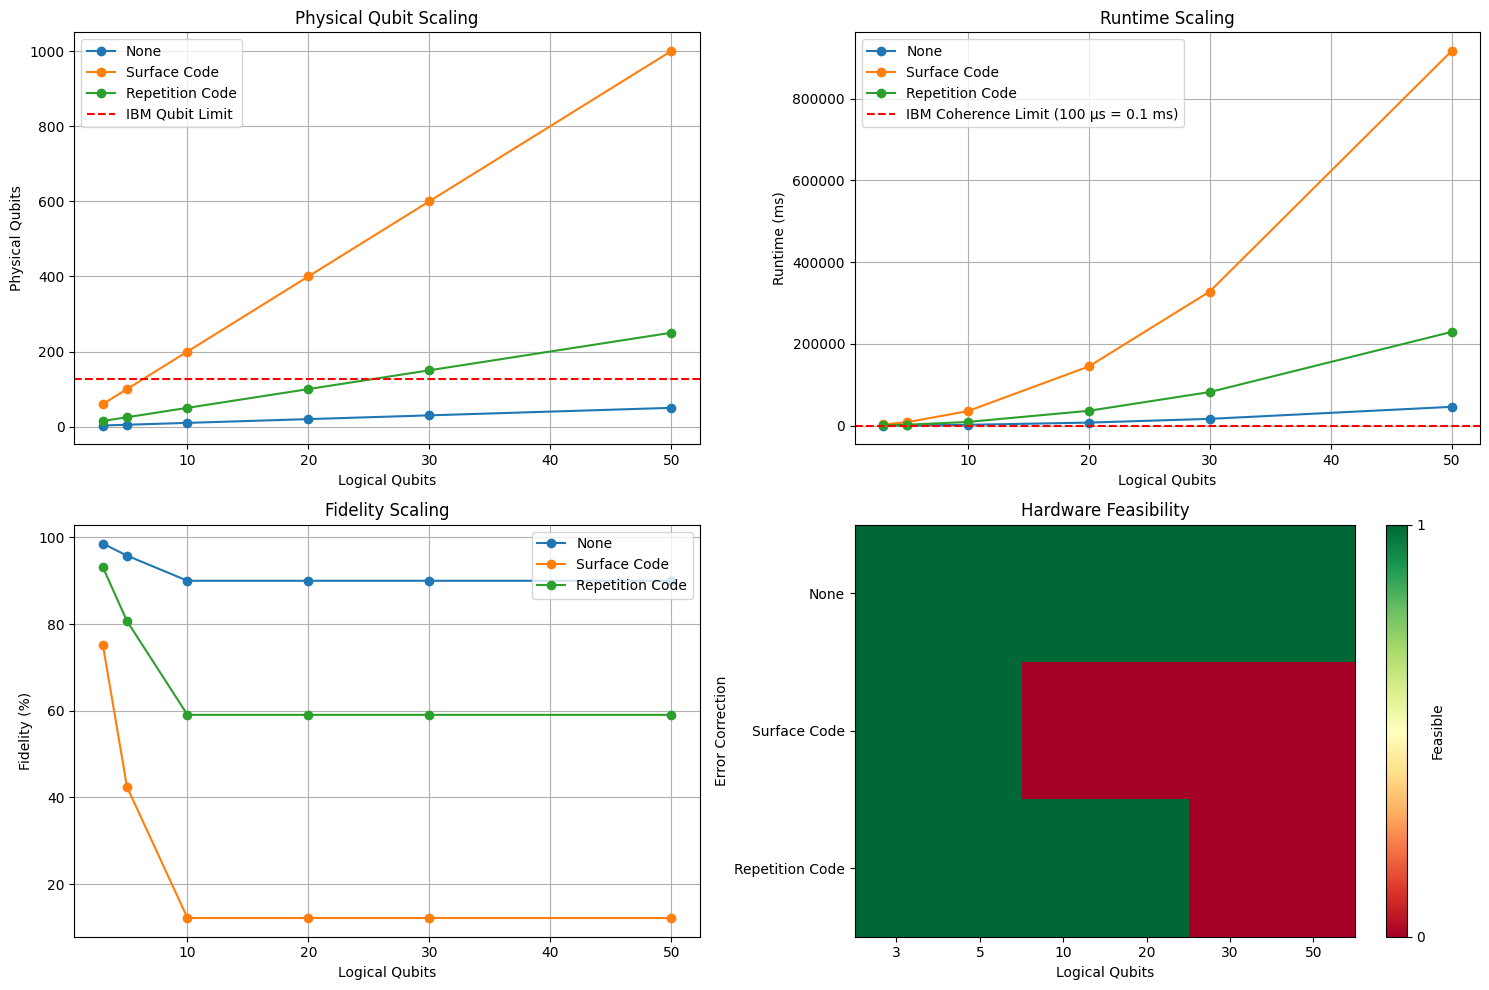

Maximum number of QFT qubits feasible on IBM hardware:
  - With None: 50 qubits
  - With Surface Code: 5 qubits
  - With Repetition Code: 20 qubits


In [13]:
# Visualize scaling results
plt.figure(figsize=(15, 10))

# Physical qubit scaling by error correction method
plt.subplot(2, 2, 1)
for ec in ERROR_CORRECTION_CODES.keys():
    ec_data = scaling_results[scaling_results['Error Correction'] == ec]
    plt.plot(ec_data['Qubits'], ec_data['Physical Qubits'], marker='o', label=ec)
    
plt.title('Physical Qubit Scaling')
plt.xlabel('Logical Qubits')
plt.ylabel('Physical Qubits')
plt.legend()
plt.grid(True)

# Add IBM's qubit limit as horizontal line
plt.axhline(y=127, color='red', linestyle='--', label='IBM Qubit Limit')
plt.legend()

# Runtime scaling by error correction method
plt.subplot(2, 2, 2)
for ec in ERROR_CORRECTION_CODES.keys():
    ec_data = scaling_results[scaling_results['Error Correction'] == ec]
    plt.plot(ec_data['Qubits'], ec_data['Runtime (ms)'], marker='o', label=ec)
    
plt.title('Runtime Scaling')
plt.xlabel('Logical Qubits')
plt.ylabel('Runtime (ms)')
plt.legend()
plt.grid(True)

# Add IBM's coherence time as horizontal line
plt.axhline(y=0.1, color='red', linestyle='--', label='IBM Coherence Limit (100 µs = 0.1 ms)')
plt.legend()

# Fidelity degradation by error correction method
plt.subplot(2, 2, 3)
for ec in ERROR_CORRECTION_CODES.keys():
    ec_data = scaling_results[scaling_results['Error Correction'] == ec]
    plt.plot(ec_data['Qubits'], ec_data['Fidelity (%)'], marker='o', label=ec)
    
plt.title('Fidelity Scaling')
plt.xlabel('Logical Qubits')
plt.ylabel('Fidelity (%)')
plt.legend()
plt.grid(True)

# Hardware feasibility analysis
plt.subplot(2, 2, 4)

# Group by qubit count and error correction, count how many are feasible
feasibility = scaling_results.groupby(['Qubits', 'Error Correction'])['Exceeds Hardware'].value_counts().unstack()

# Reshape for plotting
feasible_data = []
for qubits, group_data in scaling_results.groupby('Qubits'):
    ec_feasible = {}
    for ec in ERROR_CORRECTION_CODES.keys():
        ec_data = group_data[group_data['Error Correction'] == ec]
        ec_feasible[ec] = not ec_data['Exceeds Hardware'].any()  # Feasible if no hardware limits exceeded
    feasible_data.append({'Qubits': qubits, **ec_feasible})

feasible_df = pd.DataFrame(feasible_data).set_index('Qubits')

# Plot as heatmap
plt.imshow(feasible_df.T, cmap='RdYlGn', aspect='auto')
plt.colorbar(ticks=[0, 1], label='Feasible')
plt.title('Hardware Feasibility')
plt.xlabel('Logical Qubits')
plt.ylabel('Error Correction')
plt.xticks(range(len(feasible_df.index)), feasible_df.index)
plt.yticks(range(len(feasible_df.columns)), feasible_df.columns)

plt.tight_layout()
plt.show()

# Additional analysis
print("Maximum number of QFT qubits feasible on IBM hardware:")
for ec in ERROR_CORRECTION_CODES.keys():
    ec_data = scaling_results[scaling_results['Error Correction'] == ec]
    max_feasible = ec_data[~ec_data['Exceeds Hardware']]['Qubits'].max()
    print(f"  - With {ec}: {max_feasible} qubits")

## 🎯 Conclusion and Next Steps

This notebook demonstrates the powerful hardware-aware quantum resource estimation capabilities of Orquestra QRE:

1. **Hardware Provider Analysis**: We've seen how quantum resource requirements vary significantly across hardware providers with different coherence times, qubit counts, and error rates.

2. **Error Correction Impact**: The overhead of error correction codes substantially increases physical qubit requirements and affects runtime and fidelity.

3. **Scaling Limitations**: We've identified the practical limits of running QFT circuits on current hardware, showing where circuits become infeasible due to hardware constraints.

4. **Architectural Decisions**: These analyses can inform algorithm design and hardware selection decisions for quantum computing projects.

### Next Steps

- Explore more circuit types (Grover's, VQE, QAOA)
- Implement detailed connectivity-aware SWAP overhead estimates
- Add detailed error models specific to each hardware provider
- Integrate with actual hardware backends for validation

In [14]:
# Generate different types of circuits
circuits = {
    "Bell State": circuit_gen.generate_bell_state(),
    "Grover (3q)": circuit_gen.generate_grover_search(3),
    "QFT (3q)": circuit_gen.generate_qft(3),
    "Random (4q)": circuit_gen.generate_random_circuit(4, 8)
}

# Display circuit information
for name, circuit in circuits.items():
    print(f"\n🔮 {name}:")
    print(f"   Qubits: {circuit.num_qubits}")
    print(f"   Gates: {len(circuit.gates)}")
    print(f"   Depth: {circuit.get_depth()}")
    print(f"   Gates: {[gate.name for gate in circuit.gates]}")


🔮 Bell State:
   Qubits: 2
   Gates: 2
   Depth: 2
   Gates: ['H', 'CNOT']

🔮 Grover (3q):
   Qubits: 3
   Gates: 20
   Depth: 20
   Gates: ['H', 'H', 'H', 'Z', 'H', 'X', 'H', 'X', 'H', 'X', 'H', 'CNOT', 'CNOT', 'H', 'X', 'H', 'X', 'H', 'X', 'H']

🔮 QFT (3q):
   Qubits: 3
   Gates: 9
   Depth: 9
   Gates: ['H', 'RZ', 'CNOT', 'RZ', 'CNOT', 'H', 'RZ', 'CNOT', 'H']

🔮 Random (4q):
   Qubits: 4
   Gates: 8
   Depth: 8
   Gates: ['CNOT', 'RY', 'CNOT', 'H', 'H', 'S', 'T', 'S']


## 📊 Resource Estimation Analysis

In [15]:
# Generate estimations for all circuits
estimations = {}
for name, circuit in circuits.items():
    estimation = estimator.estimate_resources(circuit)
    estimations[name] = estimation
    
    print(f"\n📈 {name} Estimation:")
    print(f"   Runtime: {estimation.estimated_runtime_ms:.1f} ms")
    print(f"   Fidelity: {estimation.estimated_fidelity*100:.1f}%")
    print(f"   Gate breakdown: {estimation.gate_breakdown}")


📈 Bell State Estimation:
   Runtime: 35.0 ms
   Fidelity: 99.7%
   Gate breakdown: {'H': 1, 'CNOT': 1}

📈 Grover (3q) Estimation:
   Runtime: 213.0 ms
   Fidelity: 97.9%
   Gate breakdown: {'H': 11, 'Z': 1, 'X': 6, 'CNOT': 2}

📈 QFT (3q) Estimation:
   Runtime: 141.0 ms
   Fidelity: 98.6%
   Gate breakdown: {'H': 3, 'RZ': 3, 'CNOT': 3}

📈 Random (4q) Estimation:
   Runtime: 105.0 ms
   Fidelity: 99.0%
   Gate breakdown: {'CNOT': 2, 'RY': 1, 'H': 2, 'S': 2, 'T': 1}


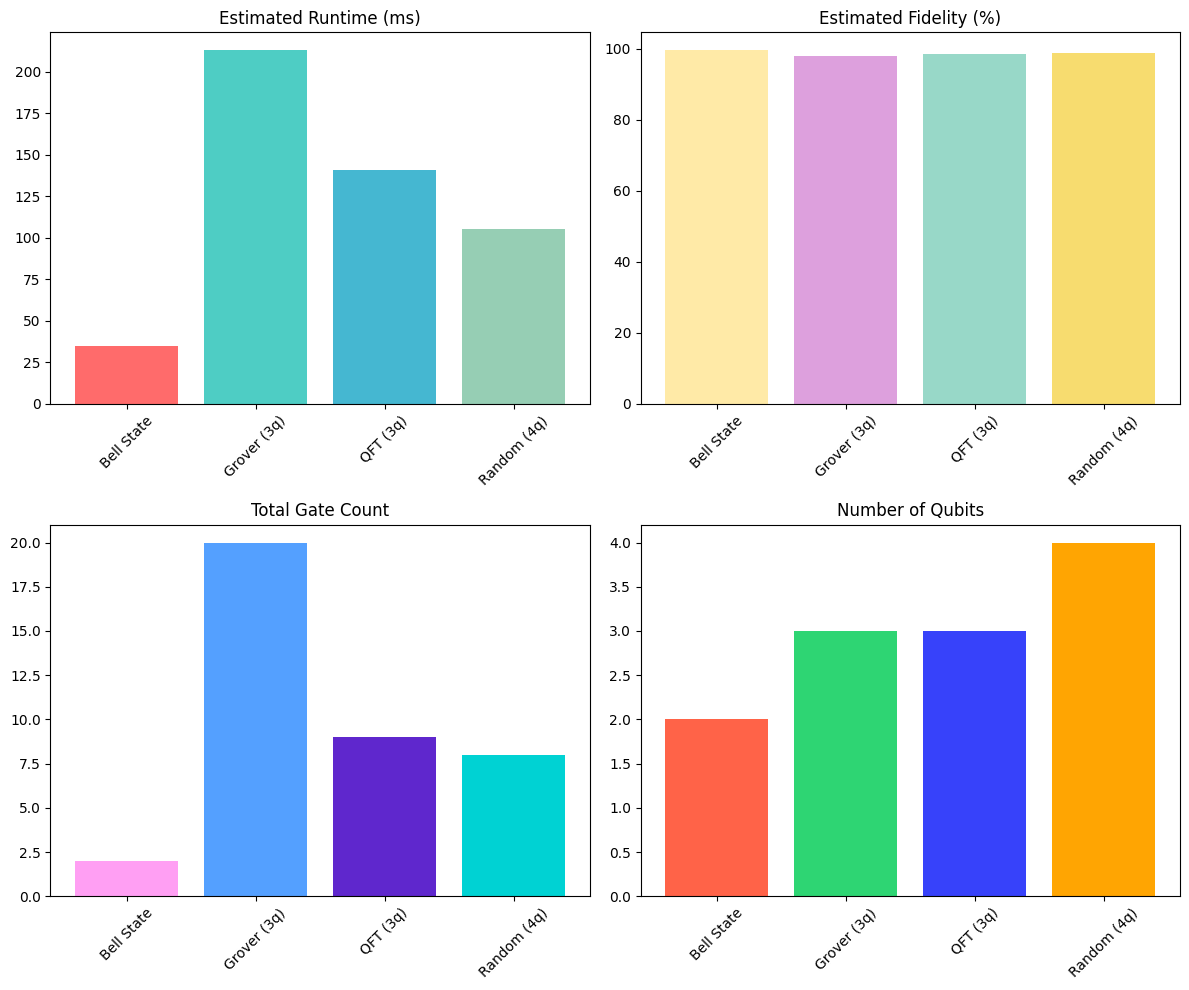

In [16]:
# Create comparison visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Runtime comparison
names = list(estimations.keys())
runtimes = [est.estimated_runtime_ms for est in estimations.values()]
ax1.bar(names, runtimes, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
ax1.set_title('Estimated Runtime (ms)')
ax1.tick_params(axis='x', rotation=45)

# Fidelity comparison
fidelities = [est.estimated_fidelity*100 for est in estimations.values()]
ax2.bar(names, fidelities, color=['#FFEAA7', '#DDA0DD', '#98D8C8', '#F7DC6F'])
ax2.set_title('Estimated Fidelity (%)')
ax2.tick_params(axis='x', rotation=45)

# Gate count comparison
gate_counts = [est.gate_count for est in estimations.values()]
ax3.bar(names, gate_counts, color=['#FF9FF3', '#54A0FF', '#5F27CD', '#00D2D3'])
ax3.set_title('Total Gate Count')
ax3.tick_params(axis='x', rotation=45)

# Qubit count comparison
qubit_counts = [est.num_qubits for est in estimations.values()]
ax4.bar(names, qubit_counts, color=['#FF6348', '#2ED573', '#3742FA', '#FFA502'])
ax4.set_title('Number of Qubits')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 🎯 Interactive Circuit Builder

In [19]:
# Enhanced interactive circuit builder with hardware awareness
def build_custom_circuit():
    print("🔧 Enhanced Custom Circuit Builder")
    num_qubits = int(input("Number of qubits (2-8): "))
    
    gates = []
    print("\nAvailable gates: H, X, Y, Z, CNOT, RZ, T, S")
    print("Enter gates one by one (format: 'GATE qubit1 [qubit2]')")
    print("Example: 'H 0' or 'CNOT 0 1'")
    print("Type 'done' to finish\n")
    
    while True:
        gate_input = input("Gate: ").strip()
        if gate_input.lower() == 'done':
            break
            
        try:
            parts = gate_input.split()
            gate_name = parts[0].upper()
            qubits = [int(q) for q in parts[1:]]
            
            from orquestra_qre.quantum import QuantumGate
            gate = QuantumGate(gate_name, qubits)
            gates.append(gate)
            print(f"✅ Added {gate_name} to qubits {qubits}")
            
        except (ValueError, IndexError):
            print("❌ Invalid format. Try again.")
    
    from orquestra_qre.quantum import QuantumCircuit
    custom_circuit = QuantumCircuit(num_qubits, gates, "Custom Circuit")
    
    print(f"\n🎉 Created circuit with {len(gates)} gates!")
    
    # Select hardware provider
    print("\nSelect Hardware Provider:")
    for i, provider in enumerate(HARDWARE_PROVIDERS):
        print(f"{i+1}. {provider.name} ({provider.max_qubits} qubits, {provider.coherence_time_us} μs coherence)")
    
    provider_idx = int(input("Enter provider number: ")) - 1
    selected_provider = HARDWARE_PROVIDERS[provider_idx]
    
    # Select error correction
    print("\nSelect Error Correction:")
    ec_options = list(ERROR_CORRECTION_CODES.keys())
    for i, ec in enumerate(ec_options):
        print(f"{i+1}. {ec}")
    
    ec_idx = int(input("Enter error correction number: ")) - 1
    selected_ec = ERROR_CORRECTION_CODES[ec_options[ec_idx]]
    
    # Estimate resources with hardware awareness
    hw_estimate = hardware_aware_estimate(custom_circuit, estimator, selected_provider, selected_ec)
    
    print(f"\n📊 Hardware-Aware Estimation Results:")
    print(f"   Provider: {selected_provider.name}")
    print(f"   Error Correction: {ec_options[ec_idx]}")
    print(f"   Logical Qubits: {hw_estimate.num_qubits}")
    print(f"   Physical Qubits: {hw_estimate.physical_qubits}")
    print(f"   Runtime: {hw_estimate.estimated_runtime_ms:.1f} ms")
    print(f"   Fidelity: {hw_estimate.estimated_fidelity*100:.1f}%")
    print(f"   Gate breakdown: {hw_estimate.gate_breakdown}")
    
    # Show warnings
    if hasattr(hw_estimate, 'hardware_warnings') and hw_estimate.hardware_warnings:
        print("\n⚠️ Hardware Warnings:")
        for warning in hw_estimate.hardware_warnings:
            print(f"   {warning}")
    
    return custom_circuit, hw_estimate

# Uncomment to run interactively
custom_circuit, custom_estimation = build_custom_circuit()

🔧 Enhanced Custom Circuit Builder

Available gates: H, X, Y, Z, CNOT, RZ, T, S
Enter gates one by one (format: 'GATE qubit1 [qubit2]')
Example: 'H 0' or 'CNOT 0 1'
Type 'done' to finish


Available gates: H, X, Y, Z, CNOT, RZ, T, S
Enter gates one by one (format: 'GATE qubit1 [qubit2]')
Example: 'H 0' or 'CNOT 0 1'
Type 'done' to finish

✅ Added H to qubits []
✅ Added H to qubits []
❌ Invalid format. Try again.
❌ Invalid format. Try again.
✅ Added X to qubits []
✅ Added X to qubits []

🎉 Created circuit with 2 gates!

Select Hardware Provider:
1. IBM (127 qubits, 100 μs coherence)
2. Google (72 qubits, 150 μs coherence)
3. IonQ (32 qubits, 1000 μs coherence)
4. Rigetti (80 qubits, 80 μs coherence)
5. Custom (1000 qubits, 10000 μs coherence)

🎉 Created circuit with 2 gates!

Select Hardware Provider:
1. IBM (127 qubits, 100 μs coherence)
2. Google (72 qubits, 150 μs coherence)
3. IonQ (32 qubits, 1000 μs coherence)
4. Rigetti (80 qubits, 80 μs coherence)
5. Custom (1000 qubits, 10000 μs